# Hypothesis: 

## Is there a significant number of accidents in rural areas caused by or involving drivers who do not live in the vicinity?

In [16]:
from pathlib import Path
import numpy as np
import pandas as pd
import datetime

import scipy.stats as stats
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import seaborn as sns

## Directory  creation and file management

In [17]:
# creating Path object for current working directory
cwd = Path('./')
root = cwd.resolve().parent
# creating Path object for additional data directory
additional_data_dir = root / 'additional_data'
# create new directory for additional data
Path(additional_data_dir).mkdir(exist_ok=True)

# creating Path object for plots directroy
plots_dir = root / 'plots'
# create new directory for plots
Path(plots_dir).mkdir(exist_ok=True)

# defining the directory to original data
data_dir = root / 'data'
additional_directory = root / 'additional_data'

# list the .csv files for the project
for file in data_dir.glob('*.csv'):
    print(file)
    
# reading in .csv files to dataframes
vehicles = pd.read_csv(data_dir / 'vehicles2019.csv', dtype={'Accident_Index': str})
casualties = pd.read_csv(data_dir / 'casualties2019.csv', dtype={'Accident_Index': str})
# cleaned accidents DataFrame
accidents = pd.read_pickle(additional_data_dir / 'accidents_cleaned.pkl')

# convert column names to lowercase for ease of indexing
def lower_columns(df):
    """
    Defintion:
        convert column names to lower case
    """
    df.columns = map(str.lower, df.columns)
    
# converting all column names to lower case
lower_columns(vehicles)
lower_columns(casualties)

accidents.head(5)

/home/jake/Documents/TrafficAccidents/data/vehicles2019.csv
/home/jake/Documents/TrafficAccidents/data/accidents2019.csv
/home/jake/Documents/TrafficAccidents/data/casualties2019.csv


,accident_index,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,local_authority_(district),local_authority_(highway),...,lsoa_of_accident_location,district,converted_date,converted_time,sunrise,sunset,day_length,datetime,decimal_time,day_of_year
0,2019010152270,-0.127949,51.436208,1,3,2,1,3,9,E09000022,...,E01003117,lambeth,2019-01-15,21:45:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 21:45:00,21.750000,15
1,2019010157567,-0.123427,51.449310,1,3,2,2,3,9,E09000022,...,E01003023,lambeth,2019-01-15,08:42:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 08:42:00,8.700000,15
2,2019010157732,-0.145106,51.461256,1,2,1,2,3,9,E09000022,...,E01003026,lambeth,2019-01-15,07:08:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 07:08:00,7.133333,15
3,2019010157896,-0.240823,51.533125,1,3,2,1,3,28,E09000005,...,E01000535,brent,2019-01-15,21:05:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 21:05:00,21.083333,15
4,2019010157795,0.161736,51.550272,1,3,1,1,3,16,E09000002,...,E01000035,barking and dagenham,2019-01-15,16:10:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 16:10:00,16.166667,15


In [46]:
# merging all three dataframes
avc = pd.merge(accidents, vehicles, on='accident_index')
avc = pd.merge(avc, casualties)

# filtering for useful information
avc = avc.filter(['accident_index', 'latitude', 'longitude',
                  'urban_or_rural_area', 'casualty_home_area_type',
                  'casualty_type', 'accident_severity'])

# filtering for accidents in rural locations
rural_accidents = avc[avc.urban_or_rural_area == 2]

print(rural_accidents.shape)

rural_accidents.head(5)

(22714, 7)


,accident_index,latitude,longitude,urban_or_rural_area,casualty_home_area_type,casualty_type,accident_severity
34,2019010157688,51.367224,0.020457,2,1,9,3
35,2019010157688,51.367224,0.020457,2,1,9,3
36,2019010157688,51.367224,0.020457,2,1,9,3
60,2019051910139,53.385046,-2.788496,2,1,9,3
61,2019051910139,53.385046,-2.788496,2,1,9,3


In [47]:
# filtering for drivers who do not live in rural areas
urban_drivers = rural_accidents[rural_accidents.casualty_home_area_type != 3]

In [48]:
urban_drivers

,accident_index,latitude,longitude,urban_or_rural_area,casualty_home_area_type,casualty_type,accident_severity
34,2019010157688,51.367224,0.020457,2,1,9,3
35,2019010157688,51.367224,0.020457,2,1,9,3
36,2019010157688,51.367224,0.020457,2,1,9,3
60,2019051910139,53.385046,-2.788496,2,1,9,3
61,2019051910139,53.385046,-2.788496,2,1,9,3
...,...,...,...,...,...,...,...
94001,2019621900363,51.651184,-3.908575,2,1,9,3
94003,201963A020219,51.689801,-4.244558,2,2,1,2
94004,201963A020219,51.689801,-4.244558,2,2,0,2
94009,2019921900152,57.147173,-2.261535,2,1,9,2


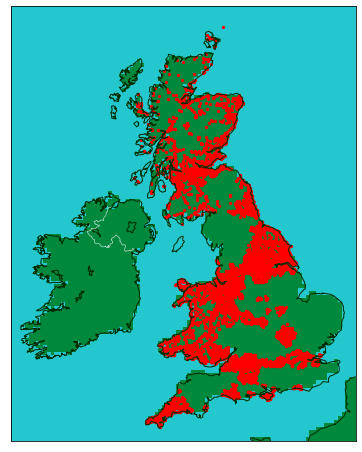

In [49]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(llcrnrlon=-10.5,llcrnrlat=49.5,urcrnrlon=3.5,urcrnrlat=59.5,
            resolution='i',projection='tmerc',lon_0=-4.36,lat_0=54.7)
m.drawcoastlines(color='#012C00')
m.drawcountries(color='white')
m.drawlsmask(land_color='#00883D', ocean_color='#23C7CD',lakes=True)

m.scatter(urban_drivers.longitude, urban_drivers.latitude,
          latlon=True,
          alpha=1,
          s=5,
          marker='o',
          color='red')


fig.savefig(plots_dir / 'rural_accidents')

In [63]:
percent_cycle_rural = (urban_drivers.casualty_type.value_counts() / urban_drivers.shape[0])
percent_cycle_all = (avc.casualty_type.value_counts() / avc.shape[0])

print(f"Percentage of cyclist casualties in rural areas: {(percent_cycle_rural * 100):.2f}%")
print(f"Percentage of cyclist casualties overall: {(percent_cycle_all * 100):.2f}%")

TypeError: unsupported format string passed to Series.__format__

In [81]:
casualty_types = pd.read_csv(additional_data_dir / 'casualty_type.csv')
casualty_types = casualty_types.merge(ratios, left_index=True, right_index=True)

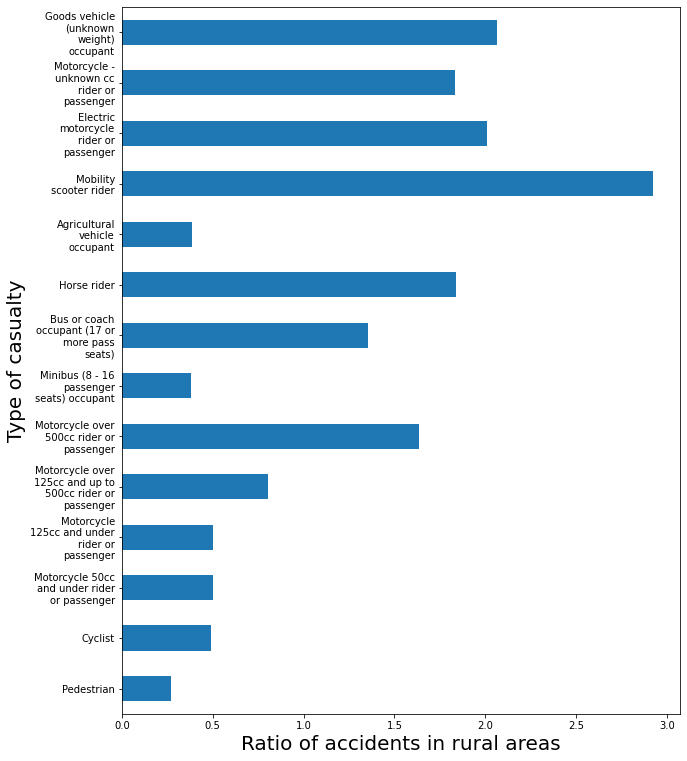

In [107]:
casualty_plot = casualty_types.plot.barh(x='label', y='casualty_type', figsize=(10, 13))
casualty_plot.set_xlabel("Ratio of accidents in rural areas", fontsize=20)
casualty_plot.set_ylabel("Type of casualty", fontsize=20)
casualty_plot.get_legend().remove()

casualty_plot.figure.savefig(plots_dir / 'casualty_rural')

In [89]:
from textwrap import wrap
labels=['Really really really really really really long label 1',
        'Really really really really really really long label 2',
        'Really really really really really really long label 3']
labels = [ '\n'.join(wrap(l, 20)) for l in labels ]

In [94]:
casualty_types['label'] = ['\n'.join(wrap(l, 15)) for l in casualty_types['label']]

In [95]:
casualty_types

,code,label,casualty_type
0,0,Pedestrian,0.271782
1,1,Cyclist,0.489627
2,2,Motorcycle 50cc\nand under rider\nor passenger,0.501052
3,3,Motorcycle\n125cc and under\nrider or\npassenger,0.500139
4,4,Motorcycle over\n125cc and up to\n500cc rider ...,0.804979
5,5,Motorcycle over\n500cc rider or\npassenger,1.635593
8,10,Minibus (8 - 16\npassenger\nseats) occupant,0.379342
9,11,Bus or coach\noccupant (17 or\nmore pass\nseats),1.356075
10,16,Horse rider,1.837779
11,17,Agricultural\nvehicle\noccupant,0.385861


In [ ]:
percent_cycle_rural = (urban_drivers.casualty_type.value_counts() / urban_drivers.shape[0])
percent_cycle_all = (avc.casualty_type.value_counts() / avc.shape[0])

print(f"Percentage of cyclist casualties in rural areas: {(percent_cycle_rural * 100):.2f}%")
print(f"Percentage of cyclist casualties overall: {(percent_cycle_all * 100):.2f}%")